In [2]:
# run only if you have not installed the next libraries
"""
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install getdist
"""


'\n!pip install numpy\n!pip install matplotlib\n!pip install scipy\n!pip install getdist\n'

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate as sci
import time
from getdist import plots, MCSamples
import time
%matplotlib inline
dpi = 200

# Gradiente de U

$\LARGE U = -\log(L(\textbf{q})p(\textbf{q})) = - \log(L) -  \log(p)$

$\LARGE \nabla_{q} U = -\frac{1}{L}\frac{\partial L}{\partial q} - \frac{1}{p}\frac{\partial p}{\partial q} = -\frac{1}{L}\frac{\partial L}{\partial q}$

Si el prior $p$ es uniforme, $\frac{\partial p}{\partial q} = 0$

$\LARGE \frac{\partial L}{\partial q} = \frac{\partial}{\partial q}(N\exp(-\frac{\chi^{2}}{2})) = -N \chi \exp(-\frac{\chi^{2}}{2})\frac{\partial \chi}{\partial q}$

$\LARGE \frac{\partial \chi}{\partial q} = \frac{\partial}{\partial q}(A - \frac{B^{2}}{C}) = \frac{\partial A}{\partial q} - 2\frac{B}{C} \frac{\partial B}{\partial q}$

$\LARGE \frac{\partial A}{\partial q} = \frac{\partial}{\partial q}(\sum_{i}\frac{(\mu_{i} - \mu)^{2}}{\sigma_{i}^{2}}) = -\sum_{i}\frac{2(\mu_{i} - \mu)}{\sigma_{i}^{2}} \frac{\partial \mu}{\partial q}$

$\LARGE \frac{\partial B}{\partial q} = \frac{\partial}{\partial q}(\sum_{i}\frac{(\mu_{i} - \mu)}{\sigma_{i}^{2}}) = - \sum_{i} \frac{1}{\sigma_{i}^{2}} \frac{\partial \mu}{\partial q}$

$\LARGE \frac{\partial \mu}{\partial q} = \frac{\partial}{\partial q} (5 \log_{10}(\bar{d}_{L})) = \frac{5}{\log{10}} \frac{1}{\bar{d}_{L}} \frac{\partial \bar{d}_{L}}{\partial q}$

$\LARGE \frac{\partial \bar{d}_{L}}{\partial q} = \frac{\partial}{\partial q}(\frac{d_{L}}{d_{H}}) = \frac{1}{d_{H}} \frac{\partial d_{L}}{\partial q}$

$\LARGE \frac{\partial d_{L}}{\partial q} = \frac{\partial}{\partial q}((1 + z)\, d_{M}) = (1 + z)\frac{\partial d_{M}}{\partial q}$

$
\begin{eqnarray}
\frac{\partial\ d_{M}}{\partial q} & = &  \left\{
	\begin{array}{ll}
		\frac{\partial f_{1}}{\partial q} & \mbox{if } \Omega_{k} > 0 \\
		\frac{\partial f_{2}}{\partial q} & \mbox{if } \Omega_{k} = 0 \\
        \frac{\partial f_{3}}{\partial q} & \mbox{if } \Omega_{k} < 0 
	\end{array}
\right.
\end{eqnarray}
$

\begin{align}
        \frac{\partial f_{1}}{\partial q} = \frac{\partial}{\partial q}(\frac{d_{H}}{\sqrt\Omega_{k}}\sinh(\sqrt{\Omega_{k}}\int_{0}^{z}\frac{dz'}{E[z']}))\\
        \frac{\partial f_{1}}{\partial q} = d_{H} [-\frac{1}{2}\Omega_{k}^{-3/2}\frac{\partial \Omega_{k}}{\partial q}\sinh(\sqrt{\Omega_{k}}\int_{0}^{z}\frac{dz'}{E(z')}) + \Omega_{k}^{-1/2}\cosh(\sqrt{\Omega_{k}}\int_{0}^{z}\frac{dz'}{E(z')})\frac{\partial}{\partial q}(\sqrt{\Omega_{k}}\int_{0}^{z}\frac{dz'}{E(z')})
\end{align}


In [91]:
# Este programa implementa Hamiltonian Markov Chain Monte Carlo. El núcleo utilizado se basa en Metropolis Hastings.

class LeapFrog:
    def __init__(self, l, e, dw, m, z, dat, sigma):
        self.l = l
        self.e = e
        self.dw = dw
        self.m = m
        self.x = z
        self.y = dat
        self.sigma = sigma
        self.dim = len(self.m)
        
    def solve(self, theta):        
        qe = theta
        while True:
            pi = np.random.multivariate_normal(mean=np.zeros(self.dim), cov=np.diag(self.m))
            pe = pi
            self.H = []
            self.X = []
            self.P = []
            self.X.append(theta)
            self.P.append(pe)
            for i in range(l):
                pe = pe - 0.5*self.e*gradiente(self.dw, qe, self.x, self.y, self.sigma) # actualiza momento en e/2
                qe = qe + self.e*pe/self.m
                if qe[0]<0:
                    qe[0] = qe[0]*-1
                    pe[0] = pe[0]*-1
                if qe[1]<0:
                    qe[1] = qe[1]*-1
                    pe[1] = pe[1]*-1
                if qe[2]>1/3:
                    qe[2] = 1/3 - qe[2]
                    pe[2] = pe[2]*-1
                pe = pe - 0.5*self.e*gradiente(self.dw, qe, self.x, self.y, self.sigma)
                self.P.append(pe)
                self.X.append(qe)
                if i + 1==l: 
                    i += 1
                self.H.append(hamiltoniano(p=pe, dat=self.y, sigma=self.sigma, theta=theta, z=self.x, m=self.m))
            if i==l: 
                break
    
    
    def get(self):
        return np.array(self.X), np.array(self.P), np.array(self.H)

    
def likelihood(mod, dat, sigma): # retorna escalar, log(L)
    sig = np.diagonal(sigma)
    L = -0.5*chi2(mod, dat, sigma)[0]  + np.sum(-0.5*np.log(2*np.pi*sig**2))
    #pp = np.argwhere((a1==-np.inf))
    #a1[pp] = 0
    return L


def chi2(mod, dat, sigma):
    sig = np.diagonal(sigma)
    AA = np.sum(((dat - mod)/sig)**2)
    BB = np.sum((dat - mod)/sig**2)	
    CC = np.sum(1/sig**2)
    chi = AA - (BB**2)/CC
    return chi, BB/CC


def prior(theta): # log(pi)
    ct = 1
    r = np.diag(np.ones(len(theta))*ct)
    p = -0.5*np.log(np.linalg.det(2*np.pi*r)) - 0.5*theta.dot((np.linalg.inv(r)).dot(theta)) 
    return p


def acepta_hmc(ec, ep, EC, EP, x, X):
    alpha = min(- EP - EC + ep + ec, 0) # log(alpha)
    u = np.log(np.random.uniform())
    if u<alpha:
        return X, EP
    else:
        return x, ep
    
    
def acepta_mh(T1, pos1, T2, pos2, m1, m2):
    alpha = min(pos2 - pos1, 0) # log(alpha)
    u = np.log(np.random.uniform())
    if u<alpha:
        return T2, pos2, m2
    else:
        return T1, pos1, m1    


def EHubble(theta, z): # parametro de hubble
    om0 = theta[0]
    ol = theta[1]
    w = theta[2]
    arg = om0*(1 + z)**3 + (1 - om0 - ol)*(1 + z)**2 + ol*(1 + z)**(3*(1 + w))
    EE = np.sqrt(arg)
    return EE, arg


def modelo(theta,z): # modulo de la distancia teorico
    om0 = theta[0]
    ol = theta[1]
    omega_k = 1 - om0 - ol
    E = EHubble(theta, z)[0]
    I = sci.cumtrapz(1/(E + 1e-300), z, initial=0)+z[0]*((1/(E + 1e-300))[0] + 1)/2 # estabilidad numerica
    o_k_s = np.sqrt(abs(omega_k))
    if omega_k==0:
        dl = (1 + z)*I
    elif omega_k<0:
        dl = (1 + z)*np.sin(o_k_s*I)/(o_k_s + 1e-300) # estabilidad numerica
    elif omega_k>0:	
        dl = (1 + z)*np.sinh(o_k_s*I)/(o_k_s + 1e-300) # estabilidad numerica
    dist = 5*np.log10(dl + 1e-300) # estabilidad numerica
    #f (-np.inf==dist).any(): 
    #    print(theta)
    return dist


def tasa(tant, tpos):
    l = len(tant)
    if np.sum(tant==tpos)==l:
        c = 0
    else:
        c = 1
    return c


def revisa(theta, z):
    arg = EHubble(theta, z)[1]
    bol = np.sum(arg<0)
    print(bol)
    if bol>0:
        a = 0 # raiz imaginaria 
    else:
        a = 1 # raiz real
    return a


def argmin2(t1, t2, t3, V): # busca en base a vector chi2 y devulve minimos de los parametros
    amin = np.argmin(V)
    return t1[amin], t2[amin], t3[amin]


def revisa1(X):
    x = X[0]
    y = X[1]
    z = X[2]
    xlim = np.array([0, 1])
    ylim = xlim
    zlim = np.array([-np.inf, 1/3])
    if xlim[0]<x<xlim[1] and ylim[0]<y<ylim[1] and zlim[0]<z<zlim[1]:
        return 1
    else:
        return 0


def potencial(dat, sigma, theta, z):
    mod = modelo(theta, z)
    u = - likelihood(mod, dat, sigma) - prior(theta) 
    return u


def cinetica(p, m):
    k = np.sum(p**2/2/m)
    return k


def hamiltoniano(p, dat, sigma, theta, z, m=1):
    h = cinetica(p, m) + potencial(dat, sigma, theta, z)
    return h


def gradiente(dw, theta, z, dat, sigma):
    tf = theta + dw
    tb = theta - dw
    grad = (potencial(dat, sigma, tf, z) - potencial(dat, sigma, tb, z))/(2*dw)
    return grad


def HMC(modelo, datos, ds, dg, N, L, params, q0, cov_mod, m, des=0.24):
    """
    datos: X, F(X)
    params: ['p1', 'p2', ..., 'pn']
    cov: matriz de covarianza de datos
    """
    # Matrices de datos de la cadena
    pid0 = PID(kp=10, ki=10, kd=10, o_min=1e-4, o_max=1e1)
    X = datos[0]
    Y = datos[1]
    chain = [] 
    post = [] 
    chi_2 = []
    Ratio = []
    acept = 0
    mod1 = modelo(q0, X)
    pos1 = potencial(Y, cov_mod, q0, X)
    Chi1 = chi2(mod1, Y, cov_mod)[0]
    chain.append(q0)
    post.append(pos1)
    chi_2.append(Chi1)
    Ratio.append(100)
    
    leap = LeapFrog(l=L, e=ds, dw=dg, m=m, z=X, dat=Y, sigma=cov_mod)

    Ti = time.time()
    for i in range(N):
        #error = des - Ratio[-1]/100
        #pid0.set_out(error)
        #m[0] = pid0.out
        q = chain[i]
        while True:
            leap.solve(q)
            Q, P, H = leap.get()
            Q1 = Q[-1]
            P1 = P[-1]
            if revisa1(Q1):
                break
        t = cinetica(P1[0], m)
        u = potencial(Y, cov_mod, q, X)
        T = cinetica(P1, m)
        U = potencial(Y, cov_mod, Q1, X)
        A = acepta_hmc(t, u, T, U, q, Q1)
        chain.append(A[0])
        post.append(A[1])
        mod1 = modelo(A[0], X)
        Chi1 = chi2(mod1, Y, cov_mod)[0]
        chi_2.append(Chi1)
        # ratio de aceptacion
        acept += tasa(chain[i], chain[i + 1]) 
        Ratio.append(acept/(i+1)*100)
        if i%10==0:
            print(i)
            print('ratio', Ratio[i])

    Tf = time.time()
    print('Tiempo cadena', np.around(Tf - Ti, 0), 's')

    ratio = acept/N*100
    print('ratio %', np.rint(ratio))

    post = np.array(post)
    chain = np.array(chain)
    chi_2 = np.array(chi_2)
    Ratio = np.array(Ratio)
    H = np.array(H)

    t1 = chain[:,0]
    t2 = chain[:,1]
    t3 = chain[:,2]

    # busca argumento del minimo de chi2
    t1m, t2m, t3m = np.around(argmin2(t1, t2, t3, chi_2),3)
    mins = [t1m, t2m, t3m]
    muestras = {}
    for i in range(len(params)):
        muestras[params[i]] = chain[:, i]
    return muestras, Ratio, chi_2, post, mins


def MH(modelo, datos, N, params, q0, cov_mod, cov_prop, des=0.24):
    """
    datos: X, F(X)
    params: ['p1', 'p2', ..., 'pn']
    cov: matriz de covarianza de datos
    """
    # Matrices de datos de la cadena
    #pid = PID(kp=10, ki=10, kd=10, o_min=2, o_max=20)
    T0 = q0
    X = datos[0]
    Y = datos[1]
    chain = [] 
    post = [] 
    chi_2 = []
    Ratio = []
    mod = []
    acept = 0
    mod0 = modelo(T0, X)
    chi0 = chi2(mod0, Y, cov_mod)[0]
    pos0 = likelihood(mod0, Y, cov_mod) + prior(T0)
    mod.append(mod0)
    chain.append(T0)
    post.append(pos0)
    chi_2.append(chi0)
    Ratio.append(100)

    # pasos de cadena
    Ti = time.time()
    for i in range(N):
        # revisa si se paso umbral de burn in
        """	
        if chi_2[i]<=580 and d==0 and o!=0:
            covarianza = COV[o]
            d = 1
            print('actualizada')
            print(covarianza)
        """	
        # selecciona ultimo elemento de la cadena
        T0 = chain[i]
        # itera hasta que encuentra un proposal valido
        while True:
            T1 = np.random.multivariate_normal(mean=T0, cov=cov_prop)
            if revisa1(T1):
                break
        # selecciona ultimo modelo
        mod0 = mod[i]
        # calcula modelo con proposal
        mod1 = modelo(T1, X)
        # selecciona ultima dis. post.
        pos0 = post[i]
        # calcula nueva dist. post.
        pos1 = likelihood(mod1, Y, cov_mod) + prior(T1)
        # decision de aceptacion
        A = acepta_mh(T0, pos0, T1, pos1, mod1, mod1)
        # guarda la variable aceptada (puede ser la anterior o proposal)
        chain.append(A[0])
        post.append(A[1])
        mod.append(A[2])
        chi_2.append(chi2(A[2], Y, cov)[0])
        # ratio de aceptacion
        acept += tasa(chain[i], chain[i + 1]) 
        Ratio.append(acept/(i+1)*100)
        if i%100==0:
            print(i)
            print('ratio', Ratio[i])

    Tf = time.time()
    print('Tiempo cadena', np.around(Tf - Ti, 0), 's')
    
    ratio = acept/N*100
    print('ratio %', np.rint(ratio))

    post = np.array(post)
    chain = np.array(chain)
    chi_2 = np.array(chi_2)
    Ratio = np.array(Ratio)
  
    t1 = chain[:,0]
    t2 = chain[:,1]
    t3 = chain[:,2]

    # busca argumento del minimo de chi2
    t1m, t2m, t3m = np.around(argmin2(t1, t2, t3, chi_2),3)
    mins = [t1m, t2m, t3m]
    muestras = {}
    for i in range(len(params)):
        muestras[params[i]] = chain[:, i]
    return muestras, Ratio, chi_2, post, mins


def plot(arr1, arr2, keys, names, save=None):
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
    ax1.scatter(arr1[0][keys[0]], arr1[0][keys[1]], marker='.', alpha=0.1)
    ax1.scatter(arr1[0][keys[0]][0], arr1[0][keys[1]][0], marker='x', color='red', alpha=1, label='inicio')
    ax1.scatter(arr1[4][0], arr1[4][1], marker='o', color='black', alpha=1, label='best fit')
    ax2.scatter(arr2[0][keys[0]], arr2[0][keys[1]], marker='.', alpha=0.1)
    ax2.scatter(arr2[0][keys[0]][0], arr2[0][keys[1]][0], marker='x', color='red', alpha=1, label='inicio')
    ax2.scatter(arr2[4][0], arr2[4][1], marker='o', color='black', alpha=1, label='best fit')
    ax1.set_title('HMC')
    ax2.set_title('MH')
    ax1.legend()
    ax2.legend()
    ax2.set_xlabel(names[0])
    ax2.set_ylabel(names[1])
    ax1.set_ylabel(names[1])
    if save!=None:
        fig.savefig('muestras_'+keys[0]+'_'+keys[1], dpi=dpi)
    return 

In [6]:
# saved things directory
direc = '/home/mauricio/Documents/Uni/Intro_2/' + 'gal.txt'

# Carga de datos
redshift = np.genfromtxt('gal.txt', usecols=(1))
mu_obs = np.genfromtxt('gal.txt', usecols=(2)) # m - M
cov = np.genfromtxt('gal.txt', usecols=(3))

p = np.argsort(redshift)
redshift = redshift[p]
mu_obs = mu_obs[p]
cov = cov[p]
cov = np.diag(cov)

In [7]:
# configuracion cadena

# params
labs = [r'$\Omega_{m}$', r'$\Omega_{\Lambda}$', r'w']
labs1 = [r'\Omega_{m}', r'\Omega_{\Lambda}', r'w']

M = -19.3182761161

## Metroplis-Hastings

In [9]:
# covarianza inicial
cov_ini = np.diag(np.array([0.4, 1.125, 4])**2)*0.5e-2
print(np.diag(cov_ini))
q0 = np.random.uniform(low=[0,0,-5], high=[1, 1, 1/3], size=3)
print('q0', q0)
R_mh = MH(modelo, [redshift, mu_obs], N=1000, params=['om', 'ol', 'w'], q0=q0, cov_mod=cov, cov_prop=cov_ini)

[0.0008     0.00632813 0.08      ]
q0 [ 0.23690635  0.03095009 -2.18867133]
0
ratio 100
100
ratio 28.999999999999996
200
ratio 33.0
300
ratio 30.0
400
ratio 28.749999999999996
500
ratio 25.4
600
ratio 24.833333333333332
700
ratio 23.714285714285715
800
ratio 22.75
900
ratio 22.333333333333332
Tiempo cadena 2.0 s
ratio % 22.0


## Hamiltonian Monte Carlo
##### Select L between 5 and 10 steps

In [97]:
ds = 1e-2
m = np.array([1, 1, 1])
print('q0', q0)
R_hmc = HMC(modelo, [redshift, mu_obs], ds=ds, dg=1e-6, N=1000, L=5, params=['om', 'ol', 'w'], 
            q0=q0, cov_mod=cov, m=m)


q0 [ 0.23690635  0.03095009 -2.18867133]
0
ratio 100
10
ratio 30.0
20
ratio 25.0
30
ratio 23.333333333333332
40
ratio 17.5
50
ratio 18.0
60
ratio 18.333333333333332
70
ratio 17.142857142857142
80
ratio 22.5
90
ratio 21.11111111111111
100
ratio 20.0
110
ratio 20.909090909090907
120
ratio 21.666666666666668
130
ratio 20.0
140
ratio 22.142857142857142
150
ratio 21.333333333333336
160
ratio 20.625
170
ratio 21.176470588235293
180
ratio 21.11111111111111
190
ratio 21.578947368421055
200
ratio 21.0
210
ratio 20.476190476190474
220
ratio 20.454545454545457
230
ratio 20.0
240
ratio 19.583333333333332
250
ratio 19.6
260
ratio 19.615384615384617
270
ratio 18.88888888888889
280
ratio 18.928571428571427
290
ratio 19.310344827586206
300
ratio 19.0
310
ratio 18.70967741935484
320
ratio 18.75
330
ratio 18.787878787878785
340
ratio 19.11764705882353
350
ratio 18.857142857142858
360
ratio 19.444444444444446
370
ratio 19.18918918918919
380
ratio 19.736842105263158
390
ratio 20.0
400
ratio 19.5
410
ratio

## Resultados

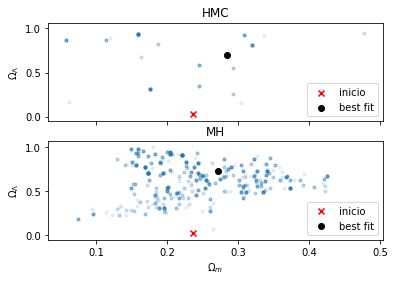

In [89]:
names = [r'$\Omega_{m}$', r'$\Omega_{\Lambda}$']
keys = ['om', 'ol']
plot(R_hmc, R_mh, keys, names, save='yes')


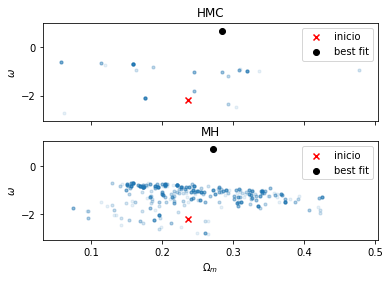

In [92]:
names = [r'$\Omega_{m}$', r'$\omega$']
keys = ['om', 'w']
plot(R_hmc, R_mh, keys, names, save='yes')

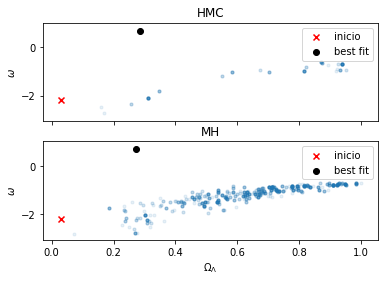

In [93]:
names = [r'$\Omega_{\Lambda}$', r'$\omega$']
keys = ['ol', 'w']
plot(R_hmc, R_mh, keys, names, save='yes please')

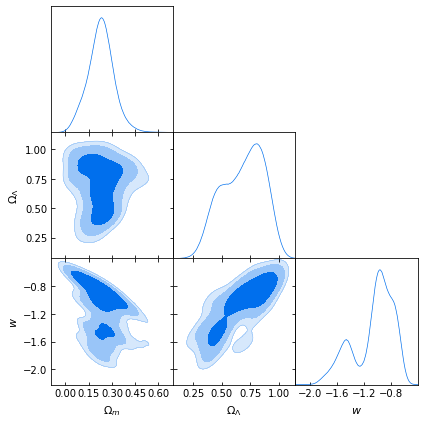

In [122]:
ndim = 3
names = ["x%s"%i for i in range(ndim)]
labels = ["x_%s"%i for i in range(ndim)]
t1 = R_hmc[0]['om']
t2 = R_hmc[0]['ol']
t3 = R_hmc[0]['w']
samps = np.vstack((t1, t2, t3)).T
samples = MCSamples(samples=samps, names=labs1, labels=labs1)

#Triangle plot
g = plots.getSubplotPlotter()
samples.updateSettings({'contours': [0.68, 0.95, 0.99]})
g.settings.num_plot_contours = 3
g.triangle_plot([samples], filled=True)


Text(0.5,1,'hmc trajectories')

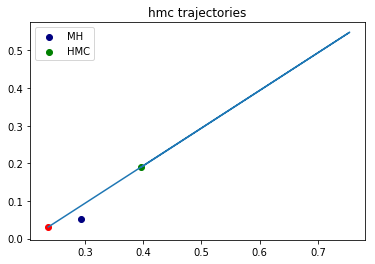

In [73]:
dw = 1e-6
e = 1e-2
l = 30
theta = q0

leap = LeapFrog(l, e, dw, m, z=redshift, dat=mu_obs, sigma=cov)
leap.solve(q0)
X = leap.get_X()
P = leap.get_P()
H = leap.get_H()
XM = np.random.multivariate_normal(mean=q0, cov=cov_ini)
plt.plot(X[:, 0], X[:, 1])
plt.scatter(q0[0], q0[1], color='red')
plt.scatter(XM[0], XM[1], color='navy', label='MH')
plt.scatter(X[-1, 0], X[-1, 1], color='green', label='HMC')
plt.legend()
plt.title('hmc trajectories')

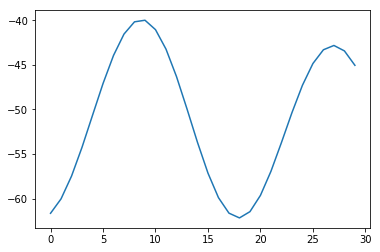

In [74]:
plt.plot(H)

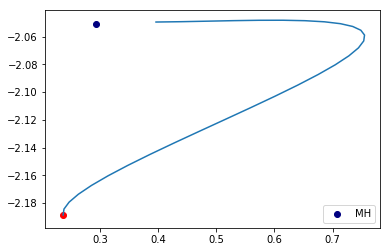

In [75]:
m[2] = 10
m[0] = 1e0
plt.plot(X[:, 0], X[:, 2])
plt.scatter(q0[0], q0[2], color='red')
plt.scatter(XM[0], XM[2], color='navy', label='MH')
plt.legend()